In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp_sparse
import sklearn.metrics as metrics
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
import scipy.sparse.linalg as linalg
import math
import time

%matplotlib inline

# STEP 1: Preprocessing and Splitting into Train and Test data


In [3]:
#Preproccesing...
scores = pd.read_csv('train.csv')
scores.drop(['id'], inplace=True, axis=1)
scores['Rating'] = scores['Rating'].apply(lambda x: 10^-15 if x == 0 else x)
scores['user_id'] = scores['user_id'].apply(lambda x: x - 1)
scores['joke_id'] = scores['joke_id'].apply(lambda x: x - 1)
scores = shuffle(scores, random_state=2021)

#keep the first 10000 as the test data
test_data = scores.head(10000).copy()

#set the ratings that we want to predict to 0
scores.iloc[0:10000, 2] = 0

#construct the Rating Matrix, rows will be the vectors of ratings for each user, set missing ratings to 0
rating_matrix = scores.pivot_table(index='user_id', columns='joke_id', values='Rating')
rating_matrix.fillna(0, inplace=True)

display(rating_matrix.head())

joke_id,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.219,-9.281,0.000,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-9.688,9.938,9.531,9.938,0.406,0.000,9.656,0.000,0.000,-9.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.000,-7.219,-2.031,-9.938,0.000,0.000,-9.812,-9.781,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.906,0.000,-5.906,0.000,0.000,3.875,6.219,0.000,6.094,5.406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.031,0.000,0.000,7.500,-7.219,0.000,0.000,0.000,3.656,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# STEP 2 UA/JA

In [13]:

def UA(A, u):
    return user_means[u]

def JA(A, j):
    return joke_means[j]

print("---------------------------------------------------------------")
start_time = time.time()
user_means = rating_matrix[rating_matrix!=0].mean(axis=1)
predictions = []
for i in range(10000):
    row = test_data.iloc[i]
    prediction = UA(rating_matrix, row['user_id'])
    predictions.append(prediction)
print("User Average RMSE: ", math.sqrt(mse(predictions, test_data['Rating'])))
print("%s seconds for UA ---" % (time.time() - start_time))
print("---------------------------------------------------------------")

start_time = time.time()
joke_means = rating_matrix[rating_matrix!=0].mean(axis=0)
predictions = []
for i in range(10000):
    row = test_data.iloc[i]
    prediction = JA(rating_matrix, row['joke_id'])
    predictions.append(prediction)
print("Joke Average RMSE: ", math.sqrt(mse(predictions, test_data['Rating'])))
print("%s seconds for JA ---" % (time.time() - start_time))
print("---------------------------------------------------------------")


---------------------------------------------------------------
User Average RMSE:  4.534468987648029
1.791278600692749 seconds for UA ---
---------------------------------------------------------------
Joke Average RMSE:  5.0604868461241646
1.8623385429382324 seconds for JA ---
---------------------------------------------------------------



We notice that the User Average algorithm is more efficient in terms of Rating predictions, while they have the same execution time.



# Collaborative Filtering Methods

## User Based Collaborative Filtering

--- 388.6914367675781 seconds for 10 similar users ---
Mean Squere Error: 4.509846040433214
---------------------------
--- 387.6416895389557 seconds for 25 similar users ---
Mean Squere Error: 4.431311067791675
---------------------------
--- 389.46700716018677 seconds for 50 similar users ---
Mean Squere Error: 4.409614759090046
---------------------------
--- 389.33389163017273 seconds for 75 similar users ---
Mean Squere Error: 4.410295167719662
---------------------------
--- 391.2342381477356 seconds for 100 similar users ---
Mean Squere Error: 4.407056688201253
---------------------------


<AxesSubplot:>

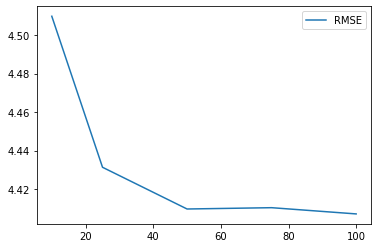

In [95]:

#convert the rating matrix into a sparse matrix in csr format
R = sp_sparse.csr_matrix(rating_matrix)

def UCF(A, k, u, j):
    
    #get vector of u, and find indices of users that rated j
    users = np.nonzero(A[:, j])[0]    
    u_vector = A[u, :]

    #compute similarities between users that rated j and user u
    vectors = A[users]
    similarities = cs(vectors, u_vector).flatten()
    
    #sort similarities and scores at the same time
    scores = vectors[:, j].data
    combined = list(zip(similarities, scores))
    combined.sort(reverse=True)
    
    #similar users should be at most k
    combined = combined[0 : k]
    lsts = list(zip(*combined))
    
    l1 = np.array(lsts[0])
    l2 = np.array(lsts[1])
    s = np.absolute(l1).sum()
    
    #case where all similarities are zero, predict mean of u
    if s == 0: return user_means[u]
    
    #finally predict the score
    return np.dot(l1.T, l2)/s

ks = [10,25,50,75,100]
error = []

for k in ks:
    predictions = []
    start_time = time.time()
    for i in range(10000):
        row = test_data.iloc[i]
        predictions.append(UCF(R, k, row['user_id'], row['joke_id']))
    print("--- %s seconds for %s similar users ---" % (time.time() - start_time, k))
    er = math.sqrt(mse(predictions, test_data['Rating']))
    error.append(er)
    print("Mean Squere Error: %s" % (er))
    print('---------------------------')
    
sns.lineplot(x=ks, y=error, legend='brief', label=str('RMSE'))


# Comments:
We observe that the number of identical users examined by the algorithm does not significantly affect the execution time. In addition, we see that as the number of like users increases, we do not have a significant decrease in RMSE.

## Item Based Collaborative Filtering

--- 217.1093623638153 seconds for 1 similar jokes ---
Mean Squere Error: 5.3148722548147855
---------------------------
--- 246.3784635066986 seconds for 2 similar jokes ---
Mean Squere Error: 4.64595559943713
---------------------------
--- 224.14435815811157 seconds for 5 similar jokes ---
Mean Squere Error: 4.24965375708707
---------------------------
--- 235.37284016609192 seconds for 7 similar jokes ---
Mean Squere Error: 4.179303796164034
---------------------------
--- 255.3895709514618 seconds for 10 similar jokes ---
Mean Squere Error: 4.157209017084698
---------------------------


<AxesSubplot:>

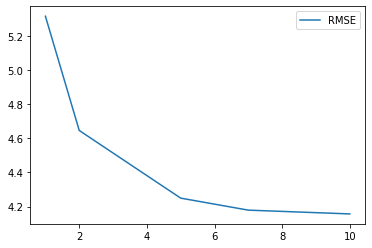

In [14]:

#convert the Transpose rating matrix into a sparse matrix in csr format, rows will be the joke vectors
R = sp_sparse.csr_matrix(rating_matrix.T)

def ICF(A, k, u, j):
    
    #get vector of J, and find indices of jokes that were rated by user u 
    j_vector = A[j, :]
    jokes = np.nonzero(A[:, u])[0] 
    
    #compute similarities between jokes that were rated by u and joke j
    vectors = A[jokes]
    similarities = cs(vectors, j_vector).flatten()

    # get scores of j' by user u then sort similarities and scores at the same time
    scores = vectors[:, u].data
    combined = list(zip(similarities, scores)) 
    combined.sort(reverse=True)
    
    #similar jokes should be at most k
    combined = combined[0 : k]
    lsts = list(zip(*combined))
    
    l1 = np.array(lsts[0])
    l2 = np.array(lsts[1])
    s = np.absolute(l1).sum()
       
    #case where all similarities are zero, predict mean of j
    if s == 0: return joke_means[j]
    
    #finally predict the score
    return np.dot(l1.T, l2)/s

ks = [1,2,5,7,10]
error = []

for k in ks:
    predictions = []
    start_time = time.time()
    for i in range(10000):
        row = test_data.iloc[i]
        predictions.append(ICF(R, k, row['user_id'], row['joke_id']))
    print("--- %s seconds for %s similar jokes ---" % (time.time() - start_time, k))
    er = math.sqrt(mse(predictions, test_data['Rating']))
    error.append(er)
    print("Mean Squere Error: %s" % (er))
    print('---------------------------')
    
sns.lineplot(x=ks, y=error, legend='brief', label=str('RMSE'))

# Comments:
For the ICF algorithm we see that it is faster than the UCF due to the smaller number of joke vectors, having significantly better performance in predictions. We observe that for 10 identical jokes we get the minimum error. In addition, we can conclude that the jokes vectors contain much more information than the users' vectors, since with only 10 we have a better RMSE than the UCF.

# SVD

--- 1.8022539615631104 seconds for rank-2 matrix ---
--- 1.7527573108673096 seconds for rank-3 matrix ---
--- 1.8066110610961914 seconds for rank-4 matrix ---
--- 1.8538153171539307 seconds for rank-5 matrix ---
--- 1.9587464332580566 seconds for rank-6 matrix ---
--- 1.8096866607666016 seconds for rank-7 matrix ---
--- 1.8566648960113525 seconds for rank-8 matrix ---
--- 1.8348093032836914 seconds for rank-9 matrix ---
--- 1.857776165008545 seconds for rank-10 matrix ---
--- 1.8306543827056885 seconds for rank-11 matrix ---
--- 1.8557493686676025 seconds for rank-12 matrix ---
--- 1.8578579425811768 seconds for rank-13 matrix ---
--- 2.093268871307373 seconds for rank-14 matrix ---
--- 1.9519994258880615 seconds for rank-15 matrix ---
--- 1.9364173412322998 seconds for rank-16 matrix ---
--- 1.9442291259765625 seconds for rank-17 matrix ---
--- 1.924891471862793 seconds for rank-18 matrix ---
--- 1.9680087566375732 seconds for rank-19 matrix ---
--- 1.981410026550293 seconds for rank-

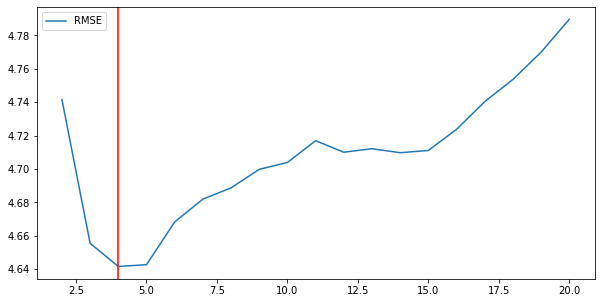

In [111]:
#convert the rating matrix into a sparse matrix in csr format
R = sp_sparse.csr_matrix(rating_matrix, dtype=float)

#Compute the largest k singular values/vectors for matrix R
def get_svd(R, k):
    u, s, vh = svds(R, k=k, which='LM')
    return np.dot(u, np.dot(np.diag(s), vh))

ks = [i for i in range(2, 21)]
err = []

for k in ks:
    start_time = time.time()
    A = get_svd(R, k)
    predictions = []
    for i in range(10000):
        row = test_data.iloc[i]
        predictions.append(A[int(row['user_id']), int(row['joke_id'])])
    err.append(math.sqrt(mse(test_data['Rating'], predictions)))
    predictions = []
    print("--- %s seconds for rank-%s matrix ---" % (time.time() - start_time, k))

print("\nBest RMSE achieved: %s with %s largest singular vectors" % (err[2], 4))

fig, axs = plt.subplots(1, figsize=(10, 5))
sns.lineplot(x=ks, y=err, legend='brief', label=str('RMSE'))
axs.axvline(x = 4, ymin = 0, ymax = 1, color ='red')

# Comments:
In the case of SVD we have very low execution times since for the predictions only the calculation of the Rank-k matrix is required. The best prediction error is the largest in relation to the previous algorithms except JA and is made in case we have k = 4 larger singular values.

## Improved-UCF Predict the deviations from the mean.

In [85]:
#center the rating matrix and keep means of users
user_means = rating_matrix[rating_matrix!=0].mean(axis=1)
norm_matrix = rating_matrix[rating_matrix!=0].sub(user_means, axis=0)
norm_matrix.fillna(0, inplace=True)

--- 422.82665252685547 seconds for 10 similar users ---
Mean Squere Error: 4.32975501622402
---------------------------
--- 383.6828668117523 seconds for 25 similar users ---
Mean Squere Error: 4.2736846278163485
---------------------------
--- 382.3979570865631 seconds for 50 similar users ---
Mean Squere Error: 4.250484992804718
---------------------------
--- 385.7773702144623 seconds for 75 similar users ---
Mean Squere Error: 4.243310959336248
---------------------------
--- 384.9828097820282 seconds for 100 similar users ---
Mean Squere Error: 4.239517465941733
---------------------------


<AxesSubplot:>

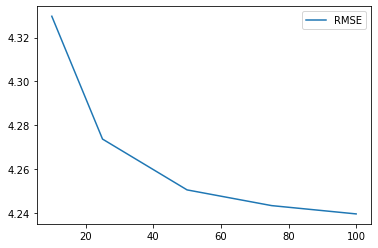

In [87]:
#convert the rating matrix into a sparse matrix in csr format
R = sp_sparse.csr_matrix(norm_matrix)

def Normalized_UCF(A, k, u, j):
    
    #get vector of u, and find indices of users that rated j
    users = np.nonzero(A[:, j])[0]    
    u_vector = A[u, :]

    #compute similarities between users that rated j and user u
    vectors = A[users]
    similarities = cs(vectors, u_vector).flatten()
    
    #sort similarities and scores at the same time
    scores = vectors[:, j].data
    combined = list(zip(similarities, scores))
    combined.sort(reverse=True)
    
    #similar users should be at most k
    combined = combined[0 : k]
    lsts = list(zip(*combined))
    
    l1 = np.array(lsts[0])
    l2 = np.array(lsts[1])
    s = np.absolute(l1).sum()
    
    #case where all similarities are zero, predict mean of u
    if s == 0: return user_means[u]
    
    #finally predict the score
    return user_means[u] + np.dot(l1.T, l2)/s

ks = [10,25,50,75,100]
error = []

for k in ks:
    predictions = []
    start_time = time.time()
    for i in range(10000):
        row = test_data.iloc[i]
        prediction = Normalized_UCF(R, k, row['user_id'], row['joke_id'])
        predictions.append(prediction)
    print("--- %s seconds for %s similar users ---" % (time.time() - start_time, k))
    er = math.sqrt(mse(predictions, test_data['Rating']))
    error.append(er)
    print("Mean Squere Error: %s" % (er))
    print('---------------------------')
    
sns.lineplot(x=ks, y=error, legend='brief', label=str('RMSE'))

We observe that a modified UCF which predicts deviations from the mean value has a significant improvement over the simple UCF.

# Cluster Based Methods
<b>A: Determine the optimal number of clusters using the SSE and SC<b/>

--- 1275.2647075653076 seconds ---


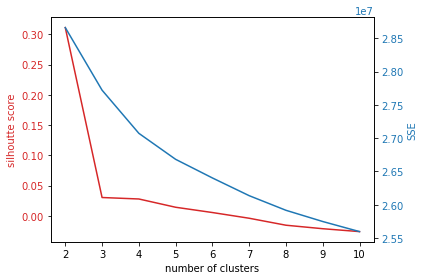

In [124]:

R = sp_sparse.csr_matrix(rating_matrix)

ks = [k for k in range(2, 11)]
results = {"sc":[], "sse":[]}

start_time = time.time()

for k in ks:
    kmeans = KMeans(init='k-means++', n_clusters=k)
    cluster_labels = kmeans.fit_predict(R)
    sse = kmeans.inertia_
    sc = metrics.silhouette_score(R, cluster_labels)
    results["sc"].append(sc)
    results["sse"].append(sse)

results["ks"] = ks

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhoutte score', color=color)
ax1.plot(results["ks"], results["sc"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('SSE', color=color) # we already handled the x-label with ax1
ax2.plot(results["ks"], results["sse"], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

print("--- %s seconds ---" % (time.time() - start_time))



From the combined graph of SC and SSE we see that ideal cluster values ​​would be k = 3 or k = 4 based on the elbow method and the sillhouete score.

## Cluster-Based JA
<b>Kmeans with n_clusters = 4 <b/>

In [91]:
R = sp_sparse.csr_matrix(rating_matrix)

#apply Kmeans on matrix R with k = 4 clusters
kmeans = KMeans(init='k-means++', n_clusters=4)
cluster_labels = np.array(kmeans.fit_predict(R))     # what cluster a user belongs to
centers = np.array(kmeans.cluster_centers_.tolist()) # 4 rating vectors of 4 users as the centers


In [167]:

def Cluster_BasedJA(A, labels, u, j):
    
    #find cluster of u and user_ids in the cluster
    cluster = labels[u]
    user_ids = np.where(labels == cluster)
    
    #get ratings of j in the cluster
    ratings = A[user_ids, j].data
    
    #return mean in the cluster or mean of j
    if len(ratings) == 0:
        return A[:, j].data.mean()
    else:
        return ratings.mean()

start_time = time.time()
err = []
for i in range(10000):
    row = test_data.iloc[i]
    x = Cluster_BasedJA(R, cluster_labels, int(row['user_id']), row['joke_id'])
    err.append(x)
print(math.sqrt(mse(err, test_data['Rating'])))
print("--- %s seconds ---" % (time.time() - start_time))

4.626514234274416
--- 51.7416627407074 seconds ---


## Cluster-BasedUCF

In [92]:
#create a sparse diagonal matrix with 1 in the corresponding rows
def slicer(A, indeces):
    extractor = np.zeros(A.shape[0], dtype=int)
    extractor[indeces] = 1
    return np.dot(sp_sparse.diags(extractor, format='csr'), A)

def Cluster_BasedUCF(A, labels, u, j):
    
    #find cluster of u and user_ids in the cluster
    cluster = labels[u]
    user_ids = np.where(labels == cluster)[0]
    
    #get the sparse submatrix
    Ah = slicer(A, user_ids)
    
    #run UCF on the submatrix
    return UCF(Ah, 100, u, j)

start_time = time.time()
err = []
for i in range(10000):
    row = test_data.iloc[i]
    x = Cluster_BasedUCF(R, cluster_labels, int(row['user_id']), row['joke_id'])
    err.append(x)
print(math.sqrt(mse(err, test_data['Rating'])))
print("--- %s seconds ---" % (time.time() - start_time))

4.36049523099198
--- 188.80969262123108 seconds ---


# NOTES
From the results we see that the algorithms achieve a similar RMSE with the previous algorithms, with the CB-UCF having better results since it uses the UCF which is generally more efficient than the algorithms that work with the means. In addition, we observe that CB-UCF is faster than the ordinary UCF since it works with similarities in a subset of data, which has already been grouped.

## Cluster-Based UA (CB-UA)

<b>A: Determine the optimal number of clusters using the SSE and SC<b/>

--- 1.263878583908081 seconds ---


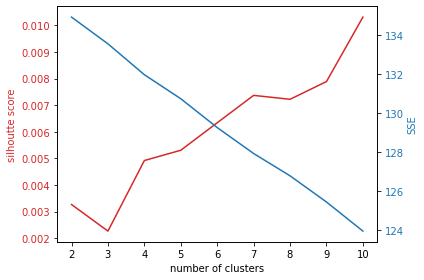

In [5]:

Jokes = pd.read_csv('jokes.csv')

###############preprocessing####################
tfidf_vectorizer = tfidf(analyzer = 'word', stop_words = 'english')
data = Jokes['joke_text'].tolist()

tfidf_matrix = tfidf_vectorizer.fit_transform(data)
################################################

ks = [k for k in range(2, 11)]
results = {"sc":[], "sse":[]}

start_time = time.time()
for k in ks:
    kmeans = KMeans(init='k-means++', n_clusters=k)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    sse = kmeans.inertia_
    sc = metrics.silhouette_score(tfidf_matrix, cluster_labels)
    results["sc"].append(sc)
    results["sse"].append(sse)

results["ks"] = ks

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhoutte score', color=color)
ax1.plot(results["ks"], results["sc"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('SSE', color=color) # we already handled the x-label with ax1
ax2.plot(results["ks"], results["sse"], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

print("--- %s seconds ---" % (time.time() - start_time))


We observe that with 6 clusters we have a balance of SC and SSE.

## Cluster-Based UA (CB-UA) with 6 clusters

In [8]:
R = sp_sparse.csr_matrix(rating_matrix.T)
kmeans = KMeans(init='k-means++', n_clusters=6)
cluster_labels = np.array(kmeans.fit_predict(tfidf_matrix))

def Cluster_BasedUA(A, labels, u, j):
    
    #grab cluster of j, and all jokes in the cluster
    cluster = labels[j]
    jokes = np.where(labels == cluster)
    
    #grab joke vectors, and rating of u
    vectors = A[jokes]
    ratings = vectors[:, u].data
    
    if len(ratings) > 0:
        return ratings.mean()
    else:
        return A[:, u].data.mean()

start_time = time.time()
err = []
for i in range(10000):
    row = test_data.iloc[i]
    x = Cluster_BasedUA(R, cluster_labels, int(row['user_id']), int(row['joke_id']))
    err.append(x)
print(math.sqrt(mse(err, test_data['Rating'])))
print("--- %s seconds ---" % (time.time() - start_time))


4.823906500758725
--- 31.954705715179443 seconds ---


# COMMENTS
We notice that the CB-UA is generally less accurate than previous algorithms, while being quite fast. This is due to the fact that the Kmeans algorithm does not achieve satisfactory clustering of jokes based on the combined diagram in which we observe a very low SC. If we reduce the number of clusters (k = 6, 5, 4, 3, 2) we have some improvement of the forecasts due to the use of UA in large clusters.